# Data Mining:  Unsupervised Exploratory Learning

##  Clustering Techniques

Clustering analysis is a type of unsupervised learning.  Clustering associates multi-dimensional data (data with many characteristics) into similar groups.  For instance, consider a collection of points in 2D space.  These can be clearly distinguished visually into three groups; it makes sense that there is a computer algorithm to do the same.

![](./img/kmc-3.png)

Other groups may be difficult to tease out given only two dimensions of information, but several clustering techniques can be used to make sense of the data.  (Of course, it ultimately falls to you, the data analyst, to decide whether or not such an association should be considered valid and useful.)

![](./img/kmc-4.png)

There are [many clustering methods](https://en.wikipedia.org/wiki/Category:Cluster_analysis_algorithms) commonly used in the trade.  We will examine two common methods:  $k$-means and hierarchical clustering.

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)

We will generate a clean random data set to demonstrate the technique initially.

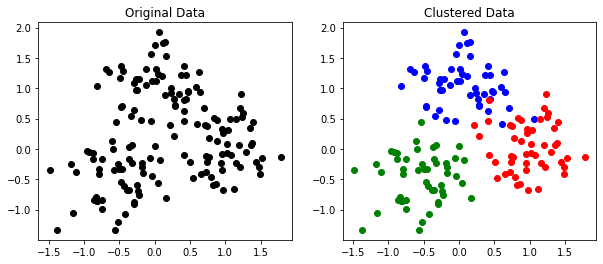

In [3]:
k = 3       # number of clusters
n = 50      # number of points per cluster

sigma = 0.4 # stdev of cluster
centers = [ ( 0,1 ),( 1,0 ),( -0.5,-0.5 ) ]

samples = np.zeros( ( k*n,2 ) )
for index,center in enumerate( centers ):
    samples[ index*n:( index+1 )*n,: ] = npr.randn( n,2 ) * sigma + center

fig,ax = plt.subplots()
plt.subplot( 1,2,1 )
plt.plot( samples[ :,0 ],samples[ :,1 ],'ko' )
plt.title( 'Original Data' )

plt.subplot( 1,2,2 )
for index,mrkr in enumerate( [ 'bo','ro','go' ] ):
    data = samples[ index*n:( index+1 )*n,: ]
    plt.plot( data[ :,0 ],data[ :,1 ],mrkr )
plt.title( 'Clustered Data' )
plt.show()

## $k$-Means Clustering

[$k$-means clustering](https://infogalactic.com/info/K-means_clustering) takes a set of observations or samples and attempts to partition them into $k$ groups or clusters.  Obviously different values of $k$ will yield different clusters.

$k$ centroids are randomly chosen in the domain*.  Clusters are created by associating every observation with the nearest centroid.  The new centroid of this updated cluster is then used, and the process proceeds iteratively to convergence.  Conveniently, cluster centroids can be suggested as well to "seed" the algorithm with suggestions from a human observer.

\*:  Specifically, the algorithm is reinitialized several times with random centroids and the best fit of several is returned.

**$k$ = 2**:

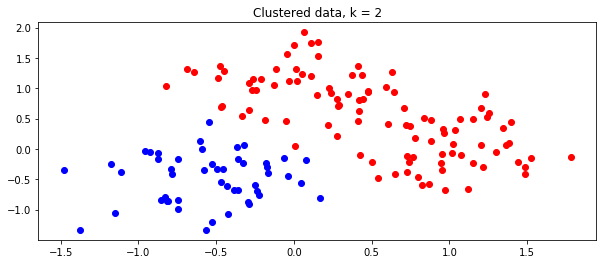

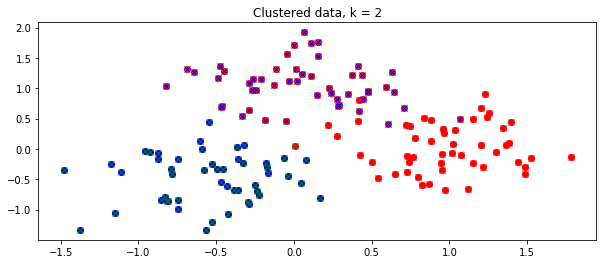

**$k$ = 3**:

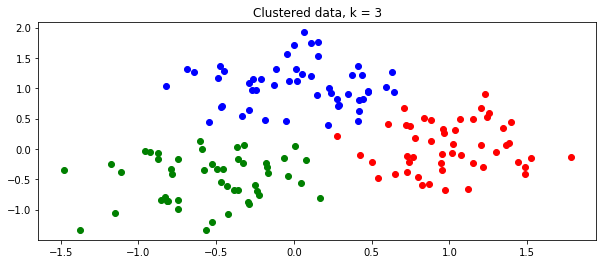

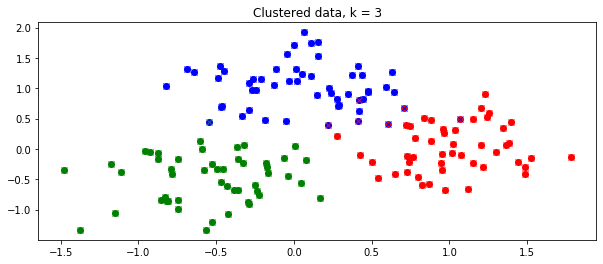

Try $k \in \{ 4..7 \}$ to explore how the model responds.  (The color vector doesn't contain more entries than seven however.)

To get the cluster centroids, use `est.cluster_centers_`.

To specify the number of cluster centers, use `est = KMeans( n_cluster=k,)`

To predict the association of new values, use `est.predict()`:

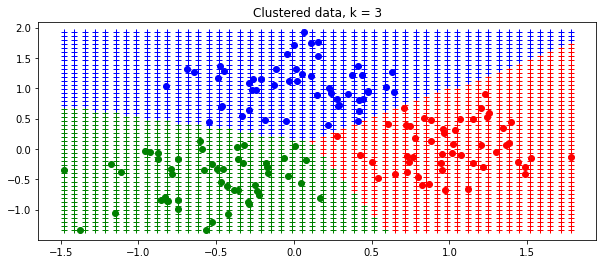

In [6]:
X,Y = np.meshgrid( np.linspace( samples[ :,0 ].min(),samples[ :,0 ].max() ),np.linspace( samples[ :,1 ].min(),samples[ :,1 ].max() ) )
X = X.ravel()
X.shape = len( X ),1
Y = Y.ravel()
Y.shape = len( Y ),1
C = est.predict( np.concatenate( ( X,Y ),axis=1 ) )

### Evaluation:  Silhouette Method

Since any $k$ yields results, we need a way to determine which set of clusters is the "best", by whatever metric.  For instance, if outside criteria dictate some number of categories, then $k$ is fixed by the external factors.  But if we are mining data abstractly, how do we distinguish the goodness of fit for several $k$s?

The silhouette method assigns a figure of merit for the separation distance between clusters.  Silhouette coefficients are in the range $[ -1,+1 ]$; positive values indicate samples are far from cluster boundaries, values near zero indicate samples are near or on boundaries, and negative values indicate that the samples may have been assigned to the wrong cluster.  (In other words, a value closer to +1 is indicative of a better fit for the particular value of $k$.)  (Note that most of the following block is plotting code.)

k = 2 yields average silhouette_score = 0.428121.


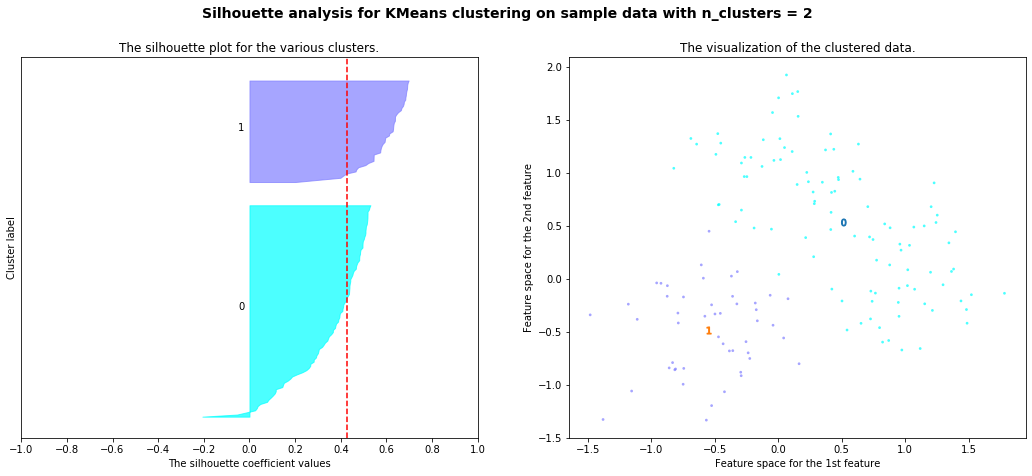

k = 3 yields average silhouette_score = 0.529113.


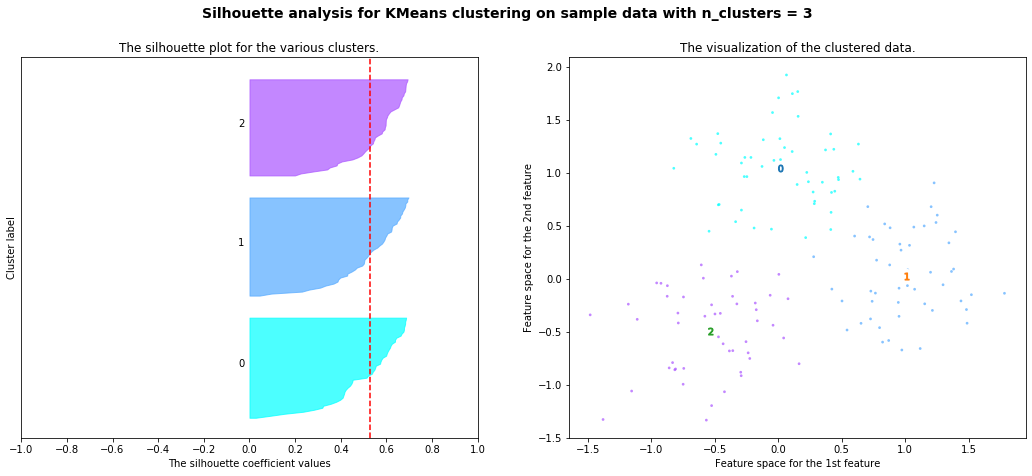

k = 4 yields average silhouette_score = 0.443743.


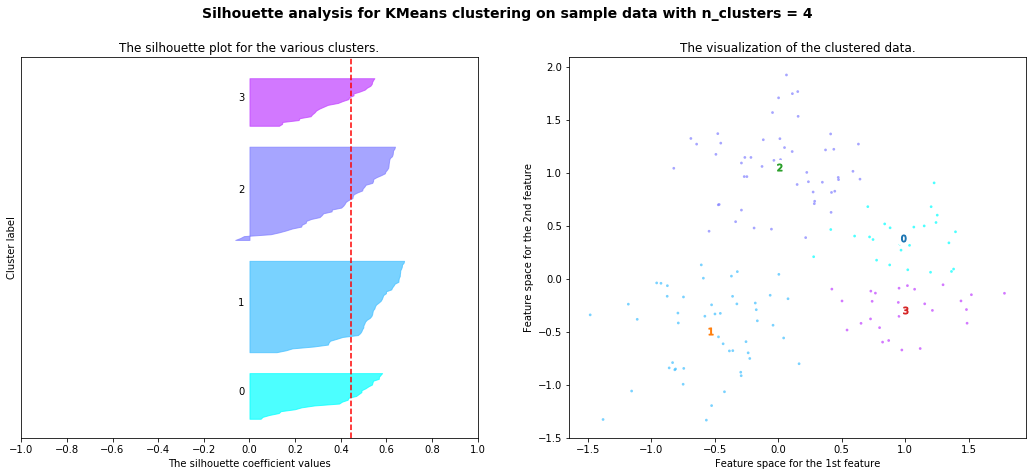

k = 5 yields average silhouette_score = 0.383542.


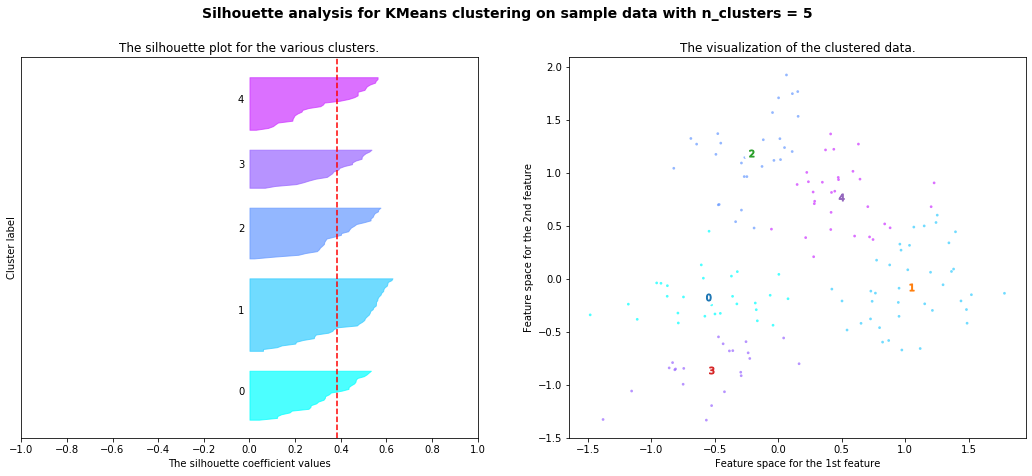

k = 6 yields average silhouette_score = 0.363419.


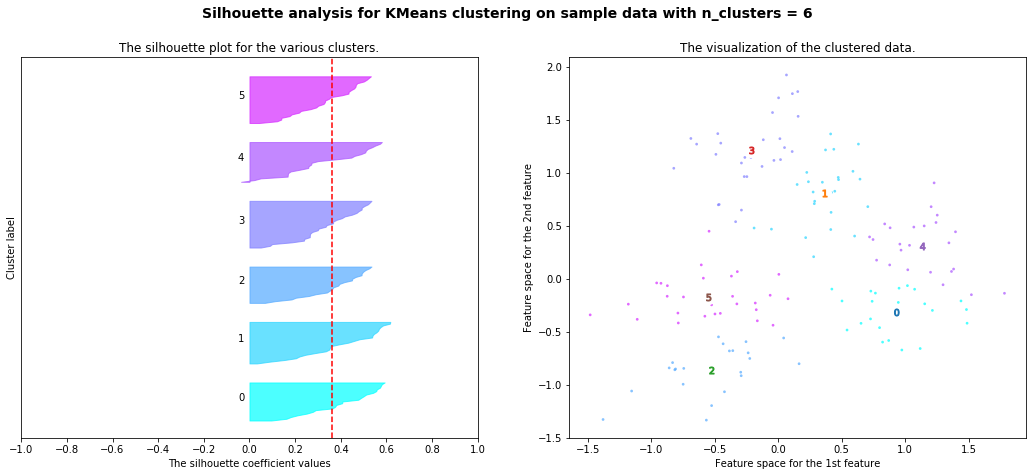

k = 7 yields average silhouette_score = 0.376408.


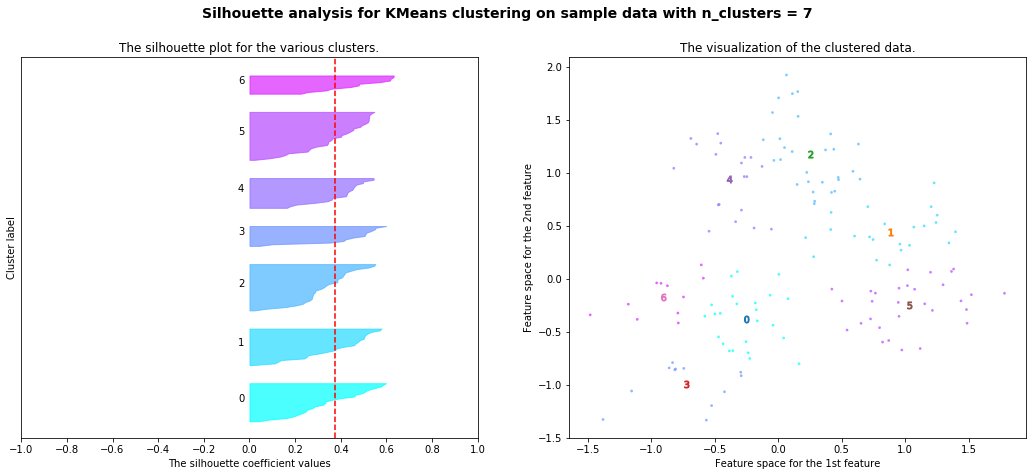

In [7]:
from sklearn.metrics import silhouette_samples, silhouette_score

k_candidates = list( range( 2,8 ) )

s_values = np.zeros( ( len( k_candidates ),1 ) )

cmap = cm.get_cmap('cool')

for k in k_candidates:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # silhouette plot
    ax1.set_xlim( [ -1,1 ] )
    ax1.set_ylim( [ 0,len( samples )+( k+1 )*10 ] )

    est = KMeans( n_clusters=k )
    C_labels = est.fit_predict( samples )

    # average silhouette score per k
    silhouette_avg = silhouette_score( samples,C_labels )
    print( "k = %d yields average silhouette_score = %f."%( k,silhouette_avg ) )

    # silhouette scores for each sample
    sample_silhouette_values = silhouette_samples( samples,C_labels )

    ## plot of silhouette scores
    y_lower = 10
    for i in range( k ):
        # aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[ C_labels == i ]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[ 0 ]
        y_upper = y_lower + size_cluster_i

        color = cmap( float( i ) / k )
        ax1.fill_betweenx( np.arange( y_lower,y_upper ),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7 )

        # label by cluster number
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title( "The silhouette plot for the various clusters." )
    ax1.set_xlabel( "The silhouette coefficient values" )
    ax1.set_ylabel( "Cluster label" )

    # average silhouette score as vertical line
    ax1.axvline( x=silhouette_avg,color='red',linestyle='--' )

    ax1.set_yticks( [] )    # clear y-axis labels/ticks
    ax1.set_xticks( np.linspace( -1,1,11 ) )

    ## plot of clusters
    colors = cmap( C_labels.astype( float ) / k )
    ax2.scatter( samples[ :,0 ],samples[ :,1 ],marker='.',s=30,lw=0,alpha=0.7,c=colors )

    # label clusters with white circles and numbers
    centers = est.cluster_centers_
    ax2.scatter( centers[ :,0 ],centers[ :,1 ],marker='o',c="white",alpha=1,s=200 )
    for i,c in enumerate( centers ):
        ax2.scatter( c[ 0 ],c[ 1 ],marker='$%d$'%i,alpha=1,s=50 )

    ax2.set_title( "The visualization of the clustered data." )
    ax2.set_xlabel( "Feature space for the 1st feature" )
    ax2.set_ylabel( "Feature space for the 2nd feature" )

    plt.suptitle( ( "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"%k ),fontsize=14,fontweight='bold' )
    plt.show()


### Evaluation:  Gap Statistics

The gap statistics method similarly assigns a figure of merit for the separation distance between clusters.  The gap statistic method seeks to maximize the gap statistic, or the spacing (gap) between clusters.  Since a `scikit-learn`-native gap statistic method has not been implemented, we will use [Miles Granger's implementation](https://github.com/milesgranger/gap_statistic).

Requirement already up-to-date: gap-stat in /home/davis68/Code/anaconda3/lib/python3.7/site-packages (2.0.1)


,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,2.0,0.482805,62.059169,9.283210,0.065305,72.457054,-0.388905,71.265942
1,3.0,0.904422,59.006033,2.833404,0.032712,68.212805,0.332814,65.025907
2,4.0,0.680508,34.095379,6.665605,0.108901,40.115254,0.161273,40.290748
3,5.0,0.685872,30.157086,9.037469,0.166636,36.352454,0.149898,33.144451
4,6.0,0.574675,18.900781,1.441764,0.038702,21.888146,0.111777,21.021626
5,7.0,0.467817,13.702733,0.155990,0.004918,15.823578,-0.031924,15.745574
6,8.0,0.527334,13.039027,0.762117,0.027594,15.081867,0.023066,14.805599
7,9.0,0.539814,11.189914,0.829899,0.035545,12.956487,0.091132,12.960249
8,10.0,0.538447,10.204998,1.847826,0.089765,11.975332,0.143305,11.520286
9,11.0,0.443601,8.092040,0.944592,0.048460,9.407327,NaN,NaN


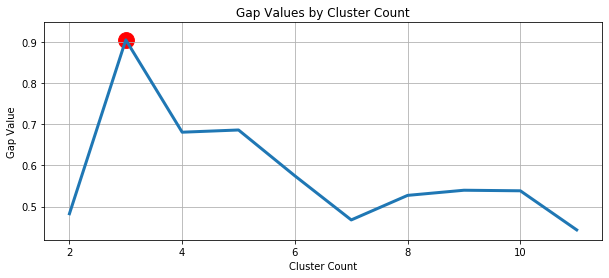

### Conclusion

$k$-means clustering is a crude but easily implemented heuristic, and sometimes does surprisingly well.  A brief analysis of its practical limits is available with [the `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py).

-   Examine the satellite data $k$-means clustering example in `satellite.ipynb`.  Once a suitable $k$ has been identified for detecting, say, snow cover or cloud cover, how transferable is that $k$ between images?  Does seeding the algorithm with certain colours help even when new colours (such as water) are present?

-   Explore the [clustering gallery](http://scikit-learn.org/stable/auto_examples/index.html#cluster-examples) for `scikit-learn`.

## Hierarchical Clustering

How many clusters does the following data set have?

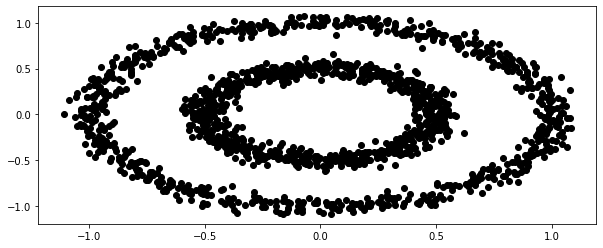

In [12]:
from sklearn.datasets import make_circles

noisy_circles = make_circles( n_samples=1500,factor=0.5,noise=0.05 )
plt.plot( noisy_circles[ 0 ][ :,0 ],noisy_circles[ 0 ][ :,1 ],'ko' )
plt.show()

KMC has a rough time with this example; using the silhouette metric, the best fit indicated has a score of 0.45 with five clusters; absolute junk!

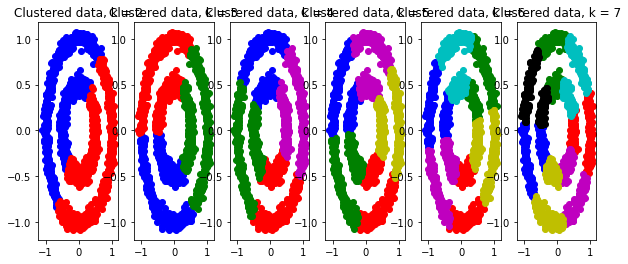

k = 2 yields average silhouette_score = 0.354738.
k = 3 yields average silhouette_score = 0.389798.
k = 4 yields average silhouette_score = 0.380268.
k = 5 yields average silhouette_score = 0.358299.
k = 6 yields average silhouette_score = 0.337300.
k = 7 yields average silhouette_score = 0.313432.


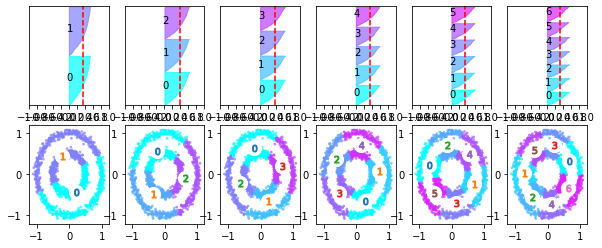

In [13]:
from sklearn.cluster import KMeans

ks = [ 2,3,4,5,6,7 ]
labels = []
for k in ks:
    est = KMeans( n_clusters=k )
    est.fit( noisy_circles[ 0 ] )
    labels.append( est.labels_ )

for k in ks:
    colors = [ 'bo','ro','go','mo','yo','co','ko' ]
    plt.subplot( 1,6,k-1 )
    for i in range( k ):
        data = noisy_circles[ 0 ][ labels[ k-2 ] == i ]
        plt.plot( data[ :,0 ],data[ :,1 ],colors[ i ] )
    plt.title( 'Clustered data, k = %i'%k )
plt.show()

###

from sklearn.metrics import silhouette_samples, silhouette_score

k_candidates = list( range( 2,8 ) )
s_values = np.zeros( ( len( k_candidates ),1 ) )

cmap = cm.get_cmap('cool')

fig,axes = plt.subplots( 2,len( k_candidates ) )
for k in k_candidates:
    # silhouette plot
    axes[ 0,k-2 ].set_xlim( [ -1,1 ] )
    axes[ 0,k-2 ].set_ylim( [ 0,len( noisy_circles[ 0 ] )+( k+1 )*10 ] )

    est = KMeans( n_clusters=k )
    C_labels = est.fit_predict( noisy_circles[ 0 ] )

    # average silhouette score per k
    silhouette_avg = silhouette_score( noisy_circles[ 0 ],C_labels )
    print( "k = %d yields average silhouette_score = %f."%( k,silhouette_avg ) )

    # silhouette scores for each sample
    sample_silhouette_values = silhouette_samples( noisy_circles[ 0 ],C_labels )

    ## plot of silhouette scores
    y_lower = 10
    for i in range( k ):
        # aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[ C_labels == i ]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[ 0 ]
        y_upper = y_lower + size_cluster_i

        color = cmap( float( i ) / k )
        axes[ 0,k-2 ].fill_betweenx( np.arange( y_lower,y_upper ),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7 )

        # label by cluster number
        axes[ 0,k-2 ].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # average silhouette score as vertical line
    axes[ 0,k-2 ].axvline( x=silhouette_avg,color='red',linestyle='--' )

    axes[ 0,k-2 ].set_yticks( [] )    # clear y-axis labels/ticks
    axes[ 0,k-2 ].set_xticks( np.linspace( -1,1,11 ) )

    ## plot of clusters
    colors = cmap( C_labels.astype( float ) / k )
    axes[ 1,k-2 ].scatter( noisy_circles[ 0 ][ :,0 ],noisy_circles[ 0 ][ :,1 ],marker='.',s=30,lw=0,alpha=0.7,c=colors )

    # label clusters with white circles and numbers
    centers = est.cluster_centers_
    axes[ 1,k-2 ].scatter( centers[ :,0 ],centers[ :,1 ],marker='o',c="white",alpha=1,s=200 )
    for i,c in enumerate( centers ):
        axes[ 1,k-2 ].scatter( c[ 0 ],c[ 1 ],marker='$%d$'%i,alpha=1,s=50 )
plt.show()

[Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) is used to build a hierarchy of clusters, from both a bottom-up (*agglomerative*) approach and a top-down (*divisive*) approach.  Because of an internal tree-like structure, HCA can often handle clusters which are visually (or conceptually) identifiable but not amenable to traditional single-level clustering analysis.  In this section, we will use agglomerative clustering to build a model which can handle data sets with "odd" features, like the above example.

As before, we will generate a clean random data set to demonstrate the technique initially.  (This process is identical to that used for the $k$-means clustering lesson.)

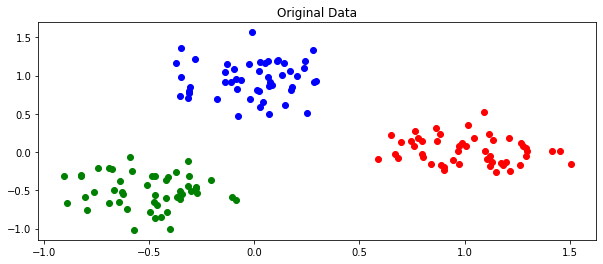

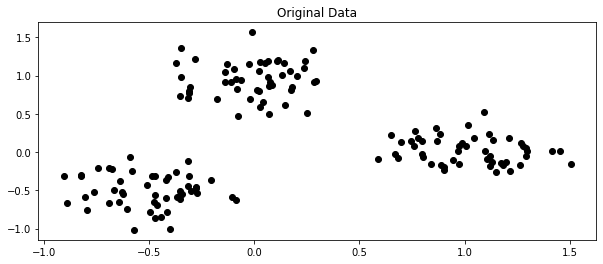

In [14]:
k = 3       # number of clusters
n = 50      # number of points per cluster

sigma = 0.2 # stdevs of clusters
centers = [ ( 0,1 ),( 1,0 ),( -0.5,-0.5 ) ]

samples = np.zeros( ( k*n,2 ) )
for index,center in enumerate( centers ):
    samples[ index*n:( index+1 )*n,: ] = npr.randn( n,2 ) * sigma + center

fig,ax = plt.subplots()
for index,mrkr in enumerate( [ 'bo','ro','go' ] ):
    data = samples[ index*n:( index+1 )*n,: ]
    ax.plot( data[ :,0 ],data[ :,1 ],mrkr )
plt.title( 'Original Data' )
plt.show()

fig,ax = plt.subplots()
plt.plot( samples[ :,0 ],samples[ :,1 ],'ko' )
plt.title( 'Original Data' )
plt.show()

### Hierarchical Clustering Method

Hierarchical clustering is provided by `scikit-learn`:

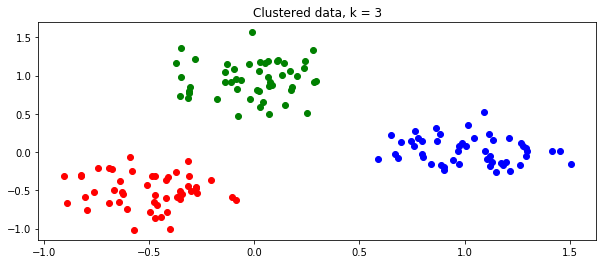

In [15]:
from sklearn.cluster import AgglomerativeClustering

k = 3
est = AgglomerativeClustering( n_clusters=k,linkage='ward' )
C = est.fit( samples )
labels = C.labels_

fig,ax = plt.subplots()
colors = [ 'bo','ro','go','mo','yo','co','ko' ]
for i in range( k ):
    data = samples[ labels == i ]
    ax.plot( data[ :,0 ],data[ :,1 ],colors[ i ] )
plt.title( 'Clustered data, k = %i'%k )
plt.show()

-   Compare the outcomes from KMC and HCA for the same $k$ clusters.

-   How do we fit our `noisy_circles` example from above?

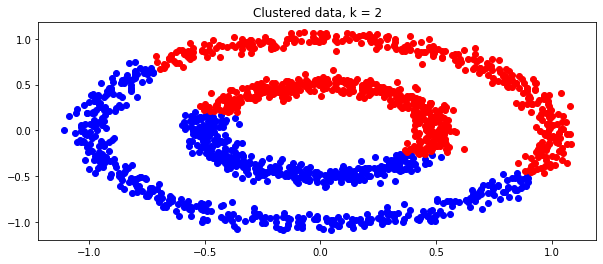

In [16]:
k = 2
est = AgglomerativeClustering( n_clusters=k,linkage='average',affinity='cityblock' )
labels = est.fit_predict( noisy_circles[ 0 ] )

fig,ax = plt.subplots()
data0 = noisy_circles[ 0 ][ labels == 0 ]
ax.plot( data0[ :,0 ],data0[ :,1 ],'bo' )
data1 = noisy_circles[ 0 ][ labels == 1 ]
ax.plot( data1[ :,0 ],data1[ :,1 ],'ro' )
plt.title( 'Clustered data, k = %i'%k )
plt.show()


That's no good!  We need connectivity information.

Since hierarchical clustering methods are built in to `scikit-learn`, we'll spend more time exploring parameters than the initial construction.

**Connectivity constraints**.  If we have some information available about how close various samples are within the entire data set (i.e., do they occur in sheets or balls), we can utilize this to constrain the system to find better fits.  An example [from the `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_ward_structured_vs_unstructured.html):

Compute unstructured hierarchical clustering...
Elapsed time: 0.04s
Number of points: 1500


/home/davis68/Code/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


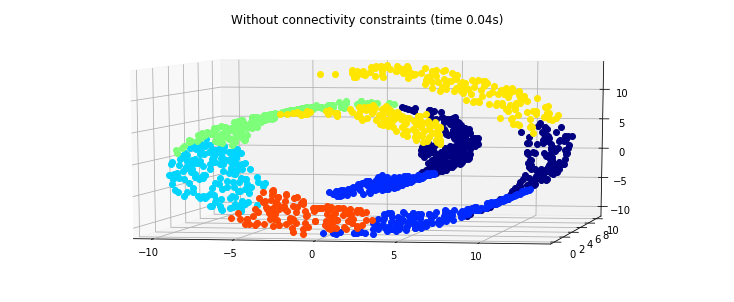

Compute structured hierarchical clustering...
Elapsed time: 0.12s
Number of points: 1500


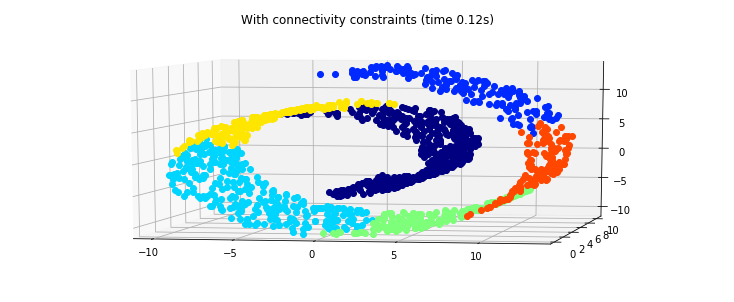

In [17]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)
# Make it thinner
X[:, 1] *= .5

# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.plot3D( X[label == l, 0], X[label == l, 1], X[label == l, 2],
               'o', color=plt.cm.jet(np.float(l) / np.max(label + 1)) )
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)
plt.show()

###

# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.plot3D(X[label == l, 0], X[label == l, 1], X[label == l, 2],
              'o', color=plt.cm.jet(float(l) / np.max(label + 1)))
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)
plt.show()

**Linkages**.  Linkage describes how the distances between sets of samples is determined.  Three common linkages are supported by `AgglomerativeClustering` in `scikit-learn`:

- `ward` minimizes the variance of the clusters being merged.
- `average` uses the average of the distances of each observation of the two sets.
- `complete` or maximum linkage uses the maximum distances between all observations of the two sets.

/home/davis68/Code/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


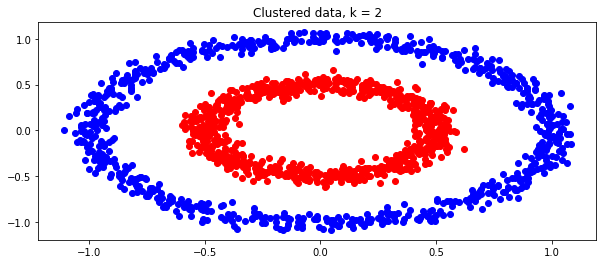

/home/davis68/Code/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/davis68/Code/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/davis68/Code/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/davis68/Code/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


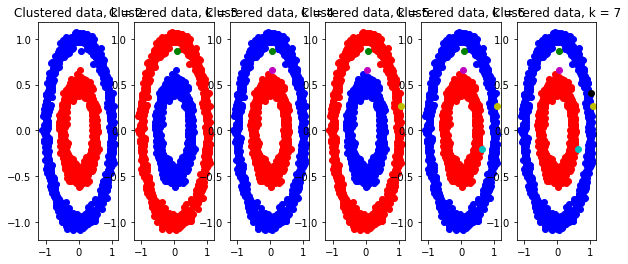

In [18]:
from sklearn.neighbors import kneighbors_graph

# connectivity matrix of structure
connectivity = kneighbors_graph( noisy_circles[ 0 ],n_neighbors=10,include_self=False )
connectivity = 0.5 * (connectivity + connectivity.T)

k = 2
est = AgglomerativeClustering( n_clusters=k,linkage='average',affinity='cityblock',connectivity=connectivity )
labels = est.fit_predict( noisy_circles[ 0 ] )

fig,ax = plt.subplots()
data0 = noisy_circles[ 0 ][ labels == 0 ]
ax.plot( data0[ :,0 ],data0[ :,1 ],'bo' )
data1 = noisy_circles[ 0 ][ labels == 1 ]
ax.plot( data1[ :,0 ],data1[ :,1 ],'ro' )
plt.title( 'Clustered data, k = %i'%k )
plt.show()

###

ks = [ 2,3,4,5,6,7 ]
labels = []
for k in ks:
    est = AgglomerativeClustering( n_clusters=k,linkage='average',affinity='cityblock',connectivity=connectivity )
    labels.append( est.fit_predict( noisy_circles[ 0 ] ) )

for k in ks:
    colors = [ 'bo','ro','go','mo','yo','co','ko' ]
    plt.subplot( 1,6,k-1 )
    for i in range( k ):
        data = noisy_circles[ 0 ][ labels[ k-2 ] == i ]
        plt.plot( data[ :,0 ],data[ :,1 ],colors[ i ] )
    plt.title( 'Clustered data, k = %i'%k )
plt.show()


Note how much better HCA performs when it comes to overestimating the number of necessary clusters; having a lot of small clusters could serve as an informal metric for higher-dimensional spaces.

The [`scikit-learn documentation`](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) illustrates more examples of hierarchical clustering.

-   What sort of metric will perform well for assessing HCA?

## Contributors

These lessons were developed by Erhu Du, Jane Lee, and Neal Davis for Computational Science and Engineering at the University of Illinois.  Development was supported by a grant from MathWorks, Inc.